# Handling Missing Data

Will Badart <badart_william@bah.com>

created: **SEP 2018**

This notebook is an explanation of different techniques for handling missing data (particularly, large swaths of missing data). We will compare how each technique affects models' performance. I'll be using [this][SO] Stack Overflow post as an outline for the different techniques we'll explore.

[SO]: https://stackoverflow.com/a/35684975/4025659

## The Dataset

I'll be using the [breast cancer][dataset] dataset from `sklearn` as a base, and performing a (reverse?) pre-processing step of removing the values from a random sampling of cells to simulate the problem of missing data.

[dataset]: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer

In [23]:
import numpy as np

from random import (
    choices, random, randint, seed as seed_py)
from sklearn.datasets import load_breast_cancer

RANDOM_STATE = 0xdecafbad
PROB_MISSING = 0.9

seed_py(RANDOM_STATE)

def should_i_do_it():
    return random() < PROB_MISSING

def stomp_indexes(x):
    options = list(range(len(x)))
    return choices(options,
                   # See NOTE below
                   weights=[6, 3, 1] * 10,
                   k=randint(0, len(x)))

X, y = load_breast_cancer(return_X_y=True)
for x in X:
    if should_i_do_it():
        targets = stomp_indexes(x)
        x[targets] = np.nan

**NOTE:** The weights here are a cycle of 30 values which alternate between `6`, `3`, and `1`. The acheived effect is that 10 of the features are missing, on average, more than 20% of the time, 10 of the features 15-20% of the time, and the remaining 10 less than 10% of the time.

This creates a distinction between "good" features (with fewer missing values) and bad ones.

## Assessing the Damage

Below, I note a few summary statistics to give an idea of the distribution of missing values.

First, we note the proportion of values which have been squashed.

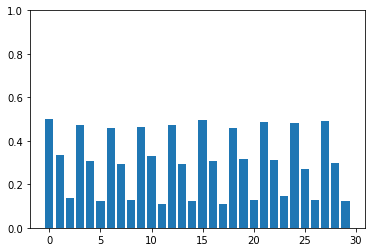

In [49]:
import matplotlib.pyplot as plt

def proportion_na(col):
    return sum(np.isnan(col)) / len(col)

proportions = [proportion_na(col) for col in X.T]
ax = plt.gca()
ax.bar(range(len(proportions)), proportions)
ax.set_ylim([0, 1])
ax

Please review the above proportions and adjust `PROB_MISSING` and the `weights` keyword argument to `choices` to your preference.

Below is the proportion of data objects with no missing values at all:

In [29]:
len([x for x in X if not any(np.isnan(x))]) / len(X)

0.14411247803163443